In [21]:
import sys
# Change path so that load_dataset function can be used
sys.path.append('./elpv-dataset-1.0/utils')
import elpv_reader
from elpv_reader import load_dataset
import numpy as np
import pandas as pd
import PIL
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from torchvision import transforms, models
from torchvision.models import shufflenet_v2_x0_5, ShuffleNet_V2_X0_5_Weights
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
import collections
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

images, proba, types = load_dataset()

# Make database mono only
# print("BEGIN")
# i = len(types) - 1
# while i >= 0:
# 	if (types[i] != 'mono'):
# 		images = np.delete(images, i, 0)
# 		proba = np.delete(proba, i, 0)
# 		types = np.delete(types, i, 0)
# 	i = i - 1
# print("DONE")

# Make database poly only
# print("BEGIN")
# i = len(types) - 1
# while i >= 0:
# 	if (types[i] != 'poly'):
# 		images = np.delete(images, i, 0)
# 		proba = np.delete(proba, i, 0)
# 		types = np.delete(types, i, 0)
# 	i = i - 1
# print("DONE")


# Load dataset, test train split and convert to tensors
proba = proba * 3
print(collections.Counter(types.tolist()))
X_train, X_test, y_train, y_test = train_test_split(images, proba, test_size=0.2, random_state=42, stratify=proba)
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)
print(collections.Counter(y_test.tolist()))
X_train_tensor = torch.tensor(X_train).unsqueeze(1).float()
X_test_tensor = torch.tensor(X_test).unsqueeze(1).float()
X_validation_tensor = torch.tensor(X_validation).unsqueeze(1).float()
y_train_tensor = torch.tensor(y_train).long()
y_test_tensor = torch.tensor(y_test).long()
y_validation_tensor = torch.tensor(y_validation).long()
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)
validation_data = TensorDataset(X_validation_tensor, y_validation_tensor)

train_len = len(list(y_train_tensor))
test_len = len(list(y_test_tensor))
validation_len = len(list(y_validation_tensor))

class Attention(nn.Module):
    def __init__(self, features):
        super().__init__()
        self.linear1 = nn.Linear(features, features)
        self.linear2 = nn.Linear(features, features)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = F.tanh(self.linear1(x))
        x = self.linear2(x)
        attention_params = self.softmax(x)
        return attention_params * x

# Shuffle network object
class ShuffleNet(nn.Module):
    def __init__(self, kernel_size=13, stride=2, padding=3, bias=False):
        super(ShuffleNet, self).__init__()
        self.shufflenet = shufflenet_v2_x0_5(weights=ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1)
        self.shufflenet.conv1 = nn.Conv2d(1, 24, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)
        # self.attention = Attention(1000)
        self.linear1 = nn.Linear(1000, 200)
        self.linear_final = nn.Linear(200, 4)

    def forward(self, x):
        x = self.shufflenet(x)
        x = x.view(x.size(0), -1)
        # x = self.attention(x)
        x = F.relu(self.linear1(x))
        x = self.linear_final(x)
        return F.log_softmax(x, dim=1)

batch_size = 128

trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
validationloader = DataLoader(validation_data, batch_size=batch_size, shuffle=False)

print("Training will begin")
def train_model(net, criterion, optimizer, epochs):
	# Train neural network and get results 
	for epoch in range(epochs):
		train_loss = 0.0
		train_acc = 0.0
		counter = 0
		for i, data in enumerate(trainloader, 0):
			counter += 1
			inputs, labels = data
			inputs = inputs.to(device)
			labels = labels.to(device)
			optimizer.zero_grad()

			outputs = net(inputs)
			loss = criterion(outputs, labels)
			loss.backward()
			optimizer.step()
			
			train_loss += loss.item()
			pred = torch.max(outputs, 1)[1]
			train_correct = (pred == labels).sum()
			train_acc += train_correct.item()
			
		print(f'Epoch {epoch + 1}, Loss: {train_loss / len(trainloader)}, Acc: {train_acc / train_len}')


def validate_model(net, criterion):
	# validation testing
	net.eval()
	val_loss = 0.0
	val_acc = 0.0
	conf_mat = torch.zeros(4,4)

	for data in validationloader:
		inputs, labels = data
		inputs = inputs.to(device)
		labels = labels.to(device)
		outputs = net(inputs)
		loss = criterion(outputs, labels)

		val_loss += loss.item()
		pred = torch.max(outputs, 1)[1]
		val_correct = (pred == labels).sum()
		val_acc += val_correct.item()
		
		for i in range(len(labels.view(-1))):
			t = labels.view(-1)[i]
			p = pred.view(-1)[i]
			conf_mat[t.long(), p.long()] += 1

	print(f'Validation Loss: {val_loss / len(validationloader)}, Validation Acc: {val_acc / validation_len}')
	class_names = ['0', '0.33', '0.66', '1']
	conf_mat_df = pd.DataFrame(conf_mat.numpy(), index=class_names, columns=class_names)
	conf_mat_df.index.name = 'True'
	print('\t\tPredicted')
	print(conf_mat_df)
	return val_acc / validation_len

def test_model(net, criterion):
	# test the trained model
	net.eval()
	test_loss = 0.0
	test_acc = 0.0

	conf_mat = torch.zeros(4,4)

	all_labels = []
	all_preds = []

	for data in testloader:
		inputs, labels = data
		inputs = inputs.to(device)
		labels = labels.to(device)
		outputs = net(inputs)
		loss = criterion(outputs, labels)

		test_loss += loss.item()
		pred = torch.max(outputs, 1)[1]
		test_correct = (pred == labels).sum()
		test_acc += test_correct.item()

		all_labels.extend(labels.view(-1).tolist())
		all_preds.extend(pred.view(-1).tolist())
		
		for i in range(len(labels.view(-1))):
			t = labels.view(-1)[i]
			p = pred.view(-1)[i]
			conf_mat[t.long(), p.long()] += 1

	print(f'Test Loss: {test_loss / len(testloader)}, Test Acc: {test_acc / test_len}')
	precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro', zero_division=0)
	print(f'Precision: {precision}, Recall: {recall}, F1: {f1}')
	class_names = ['0', '0.33', '0.66', '1']
	conf_mat_df = pd.DataFrame(conf_mat.numpy(), index=class_names, columns=class_names)
	conf_mat_df.index.name = 'True'
	print('\t\tPredicted')
	print(conf_mat_df)

def train_then_validate(kernel_size=13, stride=2, padding=3, bias=False, epochs=45):
	net = ShuffleNet(kernel_size, stride, padding, bias).to(device)

	criterion = nn.CrossEntropyLoss()
	optimizer = optim.SGD(net.parameters(), lr=0.004, momentum=0.9)
	# transform = transforms.Compose([transforms.Resize((300,300)), transforms.ToTensor()])

	train_model(net, criterion, optimizer, epochs)
	val = validate_model(net, criterion)
	return val

def train_then_test(kernel_size=13, stride=2, padding=3, bias=False, epochs=45):
	net = ShuffleNet(kernel_size, stride, padding, bias).to(device)

	criterion = nn.CrossEntropyLoss()
	optimizer = optim.SGD(net.parameters(), lr=0.004, momentum=0.9)
	# transform = transforms.Compose([transforms.Resize((300,300)), transforms.ToTensor()])

	train_model(net, criterion, optimizer, epochs)
	test = test_model(net, criterion)
	return test, net

def validator(kernels = [], strides = [], paddings = [], biass = []):
	kernel_vals = []
	stride_vals = []
	padding_vals = []
	bias_vals = []
	if (len(kernels) != 0):
		for k in kernels:
			print(f'kernel_size = {k}')
			val = train_then_validate(kernel_size=k) 
			kernel_vals.append(val)
	if (len(strides) != 0):
		for s in strides:
			print(f'stride = {s}')
			val = train_then_validate(stride=s) 
			stride_vals.append(val)
	if (len(paddings) != 0):
		for p in paddings:
			print(f'padding = {p}')
			val = train_then_validate(padding=p)
			padding_vals.append(val)
	if (len(biass) != 0):
		for b in biass:
			print(f'bias = {b}')
			val = train_then_validate(bias=b)
			bias_vals.append(val)

	if (len(kernels) != 0):
		plt.plot(kernels, kernel_vals)
		plt.title("Validation Accuracy vs Kernel Size for shufflenet")
		plt.xlabel("Kernel Size")
		plt.ylabel("Validation Accuracy")
		plt.show()
	if (len(strides) != 0):
		plt.plot(strides, stride_vals)
		plt.title("Validation Accuracy vs Stride for shufflenet")
		plt.xlabel("Stride")
		plt.ylabel("Validation Accuracy")
		plt.show()
	if (len(paddings) != 0):
		plt.plot(paddings, padding_vals)
		plt.title("Validation Accuracy vs Padding for shufflenet")
		plt.xlabel("Padding Amount")
		plt.ylabel("Validation Accuracy")
		plt.show()
	if (len(biass) != 0):
		print(biass)
		print(bias_vals)


def epoch_validity_plotter(epochs_to_do):
	epoch_nums = []
	accs = []
	for epoch in range(epochs_to_do):
		val = train_then_validate(epochs=epoch)
		epoch_nums.append(epoch + 1)
		accs.append(val)
		print(f"{epoch} DONE")

	plt.plot(epoch_nums, accs)
	plt.title("Validation Accuracy vs Epochs for shufflenet")
	plt.xlabel("Epochs")
	plt.ylabel("Validation Accuracy")
	plt.show()

kernels = [3, 7, 13, 17, 21, 25, 29]
strides = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 17]
paddings = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
bias = [True, False]

# epoch_validity_plotter(100)

# validator(kernels, strides, paddings, biass)

# train_then_validate(kernel_size=13, stride=2, padding=13, bias=False, epochs=45)

Counter({'poly': 1550, 'mono': 1074})
Counter({0.0: 151, 3.0: 71, 1.0: 29, 2.0: 11})
Training will begin


In [28]:
test, net = train_then_test(kernel_size=13, stride=2, padding=13, bias=False, epochs=45)

Epoch 1, Loss: 1.1024259223657495, Acc: 0.547879942829919
Epoch 2, Loss: 0.8342258719836965, Acc: 0.6879466412577417
Epoch 3, Loss: 0.7527255696408889, Acc: 0.7227251071939018
Epoch 4, Loss: 0.6748401277205524, Acc: 0.7398761314911863
Epoch 5, Loss: 0.6173810783554526, Acc: 0.7770366841353026
Epoch 6, Loss: 0.5817455737029805, Acc: 0.790376369699857
Epoch 7, Loss: 0.5349322697695564, Acc: 0.8108623153882801
Epoch 8, Loss: 0.484950791386997, Acc: 0.8189614101953311
Epoch 9, Loss: 0.48621083708370433, Acc: 0.8222963315864698
Epoch 10, Loss: 0.4006517178872052, Acc: 0.8599333015721772
Epoch 11, Loss: 0.35739625815083, Acc: 0.8761314911862792
Epoch 12, Loss: 0.32907211429932537, Acc: 0.883754168651739
Epoch 13, Loss: 0.31248969540876503, Acc: 0.8889947594092424
Epoch 14, Loss: 0.2896166268516989, Acc: 0.9018580276322058
Epoch 15, Loss: 0.24046369948807886, Acc: 0.9194854692710814
Epoch 16, Loss: 0.18889101769994288, Acc: 0.9371129109099571
Epoch 17, Loss: 0.1847850426154978, Acc: 0.9394949

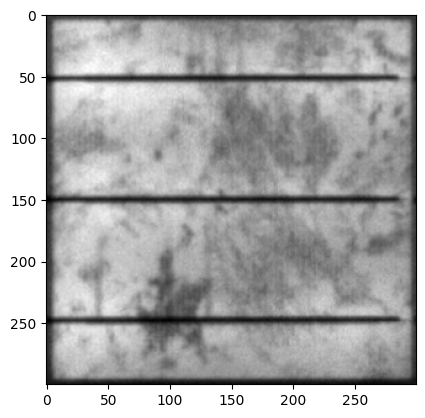

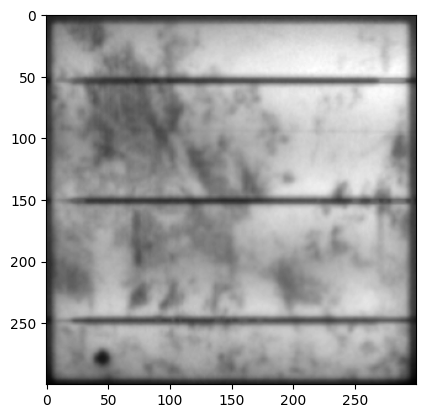

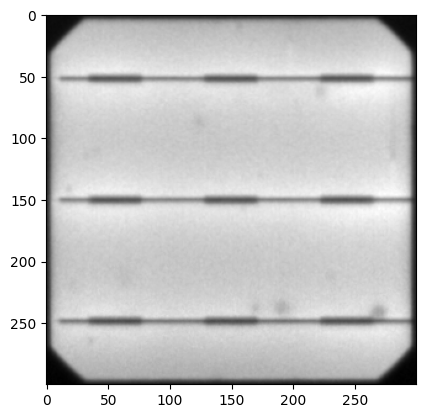

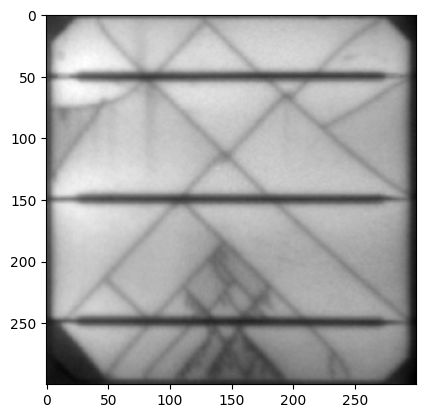

In [25]:
def index_to_image(index):
	input, label = test_data[index]
	image = input.permute(1,2,0)
	image = image.numpy()
	plt.imshow(image, cmap='gray')
	plt.show()

index_to_image(0)
index_to_image(7)
index_to_image(3)
index_to_image(2)

In [26]:
def class_mapper(num):
	if (num == 0):
		return 'Fully Functional'
	elif (num == (1 / 3)):
		return 'Possibly Defective'
	elif (num == (2 / 3)):
		return 'Likely Defective'
	elif (num == (3 / 3)):
		return 'Certainly Defective'


def predicted_vs_actual(index):
	input, label = test_data[index] 
	print(f"Actual:\t\t{class_mapper(float(label.to('cpu').item()) / 3)}")
	input = input.to(device)
	image = input.unsqueeze(0)
	output = net(image)
	_, predicted_class = torch.max(output, 1)
	class_names = ['Fully Functional', 'Possibly Defective', 'Likely Defective', 'Certainly Defective']
	print(f"Predicted: \t{class_names[predicted_class.to('cpu').item()]}")

predicted_vs_actual(0)
predicted_vs_actual(7)
predicted_vs_actual(3)
predicted_vs_actual(2)

Actual:		Fully Functional
Predicted: 	Fully Functional
Actual:		Possibly Defective
Predicted: 	Fully Functional
Actual:		Likely Defective
Predicted: 	Fully Functional
Actual:		Certainly Defective
Predicted: 	Certainly Defective
